In [1]:
import anndata as ad
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scvi
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold, train_test_split

/home/albert.baichorov/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/albert.baichorov/.venv/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/albert.baichorov/.venv/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [9]:
def evaluate_cell_types(
    cell_embeddings: pd.DataFrame,
    train_model_fn,
    drop_columns: list = ['sampleName', 'secondary_type'],
    verbose: bool = True
):
    results = []
    cell_types = cell_embeddings['secondary_type'].unique()
    
    for cell_type in cell_types:
        if verbose:
            print(f"Evaluating: {cell_type}")
            
        filtered_data = cell_embeddings[cell_embeddings['secondary_type'] == cell_type] \
            .drop(columns=drop_columns)
        
        test_score = train_model_fn(filtered_data)
        
        if verbose:
            print(f"test_score: {test_score}")
            
        results.append([cell_type, test_score])
    
    return pd.DataFrame(results, columns=['cell_type', 'test r2'])

def train_model(filtered_data):

    stratify_bins = pd.qcut(filtered_data['age'], q=10, duplicates='drop')

    X_train, X_test, y_train, y_test = train_test_split(
        filtered_data.drop(columns=['age']),
        filtered_data['age'],
        test_size=0.3,
        random_state=42,
        stratify=stratify_bins
    )

    model = RandomForestRegressor(n_estimators=500, max_features=0.4, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return r2_score(y_test, y_pred)



def draw_results(report):
    report_sorted = report.sort_values(by='test r2', ascending=True)

    fig, ax = plt.subplots(figsize=(6, 6))

    colors = plt.cm.Blues((report_sorted['test r2'] - report_sorted['test r2'].min()) /
                        (report_sorted['test r2'].max() - report_sorted['test r2'].min()))

    ax.scatter(report_sorted['test r2'], report_sorted['cell_type'],
            c=colors, s=100)

    ax.set_xlabel('Variance explained on test (%)')
    ax.set_ylabel('Cell Type')
    ax.axvline(x=0, color='gray', linestyle='--')
    ax.grid(True, axis='x', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

# PCA emb 

In [8]:
cell_embeddings = pd.read_csv('/home/albert.baichorov/ImSysAging/data/scRNA-seqEmbAge.csv', index_col=0)
cell_embeddings = cell_embeddings.drop(columns=['primary_type']).groupby(['sampleName','secondary_type','age']).mean().reset_index()

Evaluating: B_Atypical_Memory
test_score: -0.0973129235268777
Evaluating: B_BCR_GNLY
test_score: 0.13015278863958069
Evaluating: B_Memory
test_score: 0.06921586066255048
Evaluating: B_Naive
test_score: -0.1914284197340299
Evaluating: CD4_Naive_CCR7
test_score: 0.7420561559389667
Evaluating: CD4_TCM_AQP3
test_score: 0.5975225145215045
Evaluating: CD4_TEM_ANXA1
test_score: 0.5567876965561022
Evaluating: CD4_TEM_GNLY
test_score: -0.1784853148953569
Evaluating: CD4_Treg_FOXP3
test_score: 0.46728387944468386
Evaluating: CD8_MAIT_SLC4A10
test_score: 0.30361183721230023
Evaluating: CD8_Naive_LEF1
test_score: 0.5642314488705495
Evaluating: CD8_TCM_HAVCR2
test_score: 0.42543098199763907
Evaluating: CD8_TEM_CMC1
test_score: 0.2770155360524784
Evaluating: CD8_TEM_GNLY
test_score: 0.49911395808677395
Evaluating: CD8_TEM_ZNF683
test_score: 0.55813982766538
Evaluating: Mega
test_score: 0.13225359740328457
Evaluating: Monocytes_CD14
test_score: 0.00770870294208803
Evaluating: Monocytes_CD16
test_scor

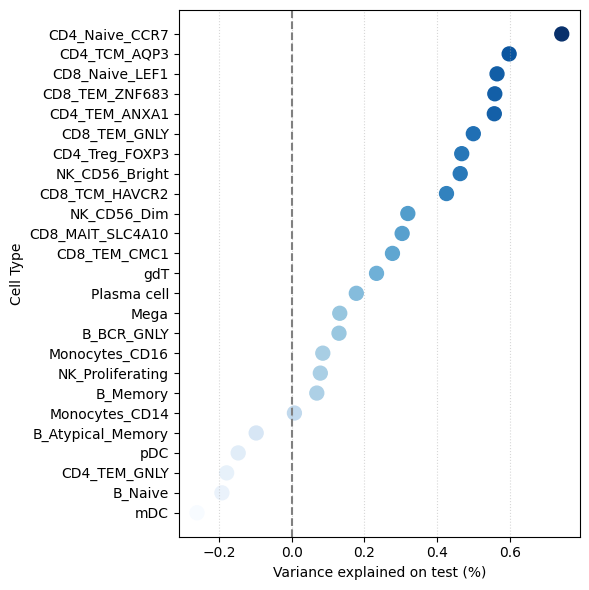

In [33]:
report = evaluate_cell_types(cell_embeddings, train_model)
draw_results(report)

# MRVI embedings, no specified batch

In [2]:
adata = ad.read_h5ad("/home/albert.baichorov/ImSysAging/data/scRNA-seq_MRVI_no_batch.h5ad")

## Lets start with context-free embedings U

In [ ]:
data = pd.concat([adata.obs[['sampleName','primary_type','secondary_type','age']].reset_index(drop=True),
                  pd.DataFrame(adata.obsm['U_mrvi']).reset_index(drop=True)], axis=1)
data = data.drop(columns='primary_type').groupby(['sampleName','secondary_type','age']).mean().reset_index()
data = data.dropna()
data.sampleName = data.sampleName.astype('str')
data.secondary_type = data.secondary_type.astype('str')
data.age = data.age.astype('float')
report = evaluate_cell_types(data, train_model)
draw_results(report)

/tmp/ipykernel_1830255/3966539677.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data.drop(columns='primary_type').groupby(['sampleName','secondary_type','age']).mean().reset_index()


Evaluating: B_Atypical_Memory
test_score: 0.1762010639278725
Evaluating: B_BCR_GNLY
test_score: 0.33594423082054703
Evaluating: B_Memory
test_score: 0.18427841510330079
Evaluating: B_Naive
test_score: 0.15861211315601964
Evaluating: CD4_Naive_CCR7
test_score: 0.2549230664671518
Evaluating: CD4_TCM_AQP3
test_score: -0.022688635182623873
Evaluating: CD4_TEM_ANXA1
test_score: 0.33307997175051585
Evaluating: CD4_TEM_GNLY
test_score: 0.2740224446674845
Evaluating: CD4_Treg_FOXP3
test_score: -0.37708892765320656
Evaluating: CD8_MAIT_SLC4A10
test_score: 0.16461939099779455
Evaluating: CD8_Naive_LEF1
test_score: 0.07236948008252664
Evaluating: CD8_TCM_HAVCR2
test_score: 0.185584138608342
Evaluating: CD8_TEM_CMC1
test_score: 0.41294349232548133
Evaluating: CD8_TEM_GNLY
test_score: 0.19413401895390758
Evaluating: CD8_TEM_ZNF683
test_score: 0.5628322938573139
Evaluating: Mega
test_score: 0.13094948815380802
Evaluating: Monocytes_CD14
test_score: -0.026870643435282116
Evaluating: Monocytes_CD16
te

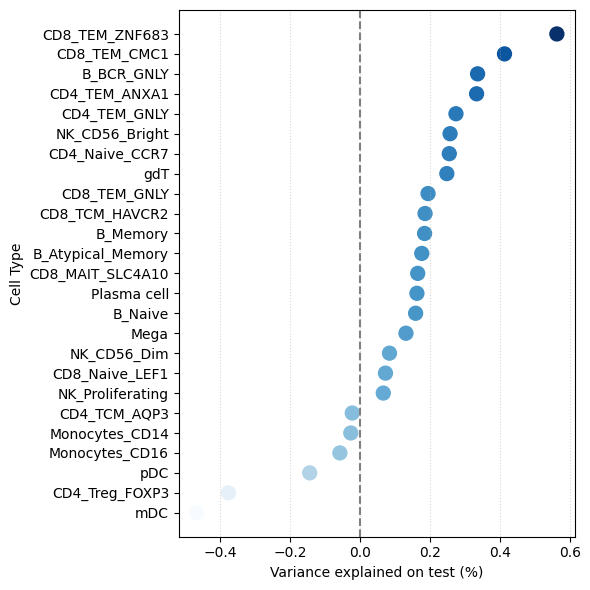

In [14]:
report = evaluate_cell_types(data, train_model)
draw_results(report)

# Z embedings

/tmp/ipykernel_1830255/4053201791.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data.drop(columns='primary_type').groupby(['sampleName','secondary_type','age']).mean().reset_index()


Evaluating: B_Atypical_Memory
test_score: 0.5057161793063838
Evaluating: B_BCR_GNLY
test_score: 0.41389963650563777
Evaluating: B_Memory
test_score: 0.528512357605082
Evaluating: B_Naive
test_score: 0.2528338865768226
Evaluating: CD4_Naive_CCR7
test_score: 0.717329245123601
Evaluating: CD4_TCM_AQP3
test_score: 0.5999862634653608
Evaluating: CD4_TEM_ANXA1
test_score: 0.4424608214871413
Evaluating: CD4_TEM_GNLY
test_score: 0.5471193939258763
Evaluating: CD4_Treg_FOXP3
test_score: 0.525600252733882
Evaluating: CD8_MAIT_SLC4A10
test_score: 0.38860299278219623
Evaluating: CD8_Naive_LEF1
test_score: 0.7205386344722304
Evaluating: CD8_TCM_HAVCR2
test_score: 0.5805985665988982
Evaluating: CD8_TEM_CMC1
test_score: 0.5075532523333409
Evaluating: CD8_TEM_GNLY
test_score: 0.4153105499202696
Evaluating: CD8_TEM_ZNF683
test_score: 0.6405116712032477
Evaluating: Mega
test_score: 0.23489300832067483
Evaluating: Monocytes_CD14
test_score: 0.2858952151510342
Evaluating: Monocytes_CD16
test_score: 0.4100

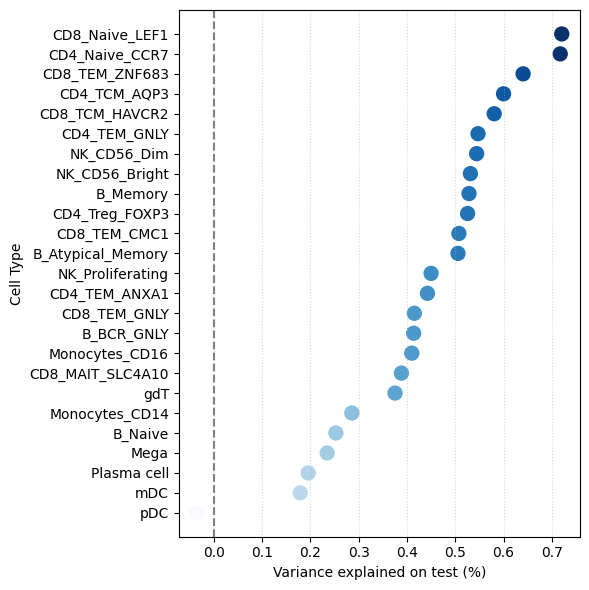

In [15]:
data = pd.concat([adata.obs[['sampleName','primary_type','secondary_type','age']].reset_index(drop=True),
                  pd.DataFrame(adata.obsm['Z_mrvi']).reset_index(drop=True)], axis=1)
data = data.drop(columns='primary_type').groupby(['sampleName','secondary_type','age']).mean().reset_index()
data = data.dropna()
data.sampleName = data.sampleName.astype('str')
data.secondary_type = data.secondary_type.astype('str')
data.age = data.age.astype('float')
report = evaluate_cell_types(data, train_model)
draw_results(report)

# MRVI embedings, sample batch

In [16]:
adata = ad.read_h5ad("/home/albert.baichorov/ImSysAging/data/scRNA-seq_MRVI_sample_batch.h5ad")

# U embedings

/tmp/ipykernel_1830255/343497697.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data.drop(columns='primary_type').groupby(['sampleName','secondary_type','age']).mean().reset_index()


Evaluating: B_Atypical_Memory
test_score: 0.20431853645301978
Evaluating: B_BCR_GNLY
test_score: 0.42957246396784843
Evaluating: B_Memory
test_score: 0.01989964922227483
Evaluating: B_Naive
test_score: 0.47754289761933033
Evaluating: CD4_Naive_CCR7
test_score: 0.3394740069830188
Evaluating: CD4_TCM_AQP3
test_score: 0.2578478318785379
Evaluating: CD4_TEM_ANXA1
test_score: 0.09985241943455703
Evaluating: CD4_TEM_GNLY
test_score: 0.37139055797182274
Evaluating: CD4_Treg_FOXP3
test_score: 0.14834865921509066
Evaluating: CD8_MAIT_SLC4A10
test_score: 0.48293312236850905
Evaluating: CD8_Naive_LEF1
test_score: 0.22488372055833927
Evaluating: CD8_TCM_HAVCR2
test_score: 0.3959120919464848
Evaluating: CD8_TEM_CMC1
test_score: 0.017948641666855836
Evaluating: CD8_TEM_GNLY
test_score: 0.0476293750500677
Evaluating: CD8_TEM_ZNF683
test_score: 0.4321541877745241
Evaluating: Mega
test_score: 0.32397792368558287
Evaluating: Monocytes_CD14
test_score: 0.12080702449346681
Evaluating: Monocytes_CD16
test_

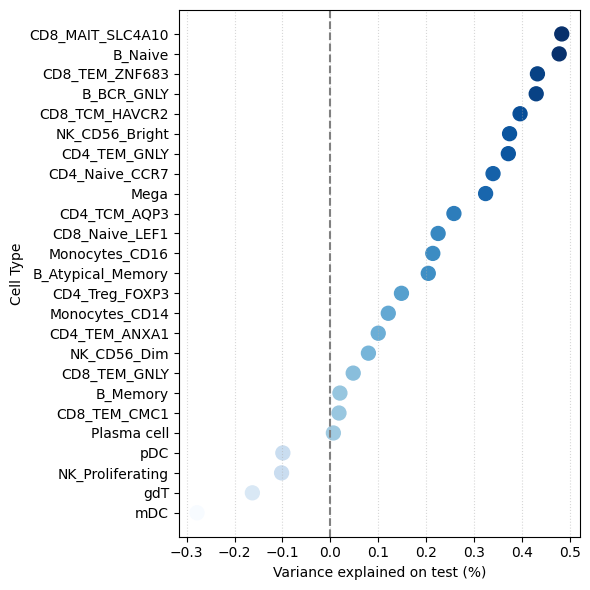

In [17]:
data = pd.concat([adata.obs[['sampleName','primary_type','secondary_type','age']].reset_index(drop=True),
                  pd.DataFrame(adata.obsm['U_mrvi']).reset_index(drop=True)], axis=1)
data = data.drop(columns='primary_type').groupby(['sampleName','secondary_type','age']).mean().reset_index()
data = data.dropna()
data.sampleName = data.sampleName.astype('str')
data.secondary_type = data.secondary_type.astype('str')
data.age = data.age.astype('float')
report = evaluate_cell_types(data, train_model)
draw_results(report)

# Z embedings

/tmp/ipykernel_1830255/4053201791.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data.drop(columns='primary_type').groupby(['sampleName','secondary_type','age']).mean().reset_index()


Evaluating: B_Atypical_Memory
test_score: -0.049197306640669014
Evaluating: B_BCR_GNLY
test_score: 0.2585969468263395
Evaluating: B_Memory
test_score: -0.12005099810021358
Evaluating: B_Naive
test_score: 0.180740940631679
Evaluating: CD4_Naive_CCR7
test_score: -0.04333596380015248
Evaluating: CD4_TCM_AQP3
test_score: -0.13984688401689827
Evaluating: CD4_TEM_ANXA1
test_score: 0.35313538419449686
Evaluating: CD4_TEM_GNLY
test_score: 0.16918607605665237
Evaluating: CD4_Treg_FOXP3
test_score: 0.11411409446724263
Evaluating: CD8_MAIT_SLC4A10
test_score: 0.05710290566731269
Evaluating: CD8_Naive_LEF1
test_score: 0.08375004514778472
Evaluating: CD8_TCM_HAVCR2
test_score: 0.3559284852439665
Evaluating: CD8_TEM_CMC1
test_score: 0.047057531638968975
Evaluating: CD8_TEM_GNLY
test_score: -0.08774429142766449
Evaluating: CD8_TEM_ZNF683
test_score: 0.5348920139757752
Evaluating: Mega
test_score: 0.17407337293400138
Evaluating: Monocytes_CD14
test_score: 0.21914483690419528
Evaluating: Monocytes_CD16

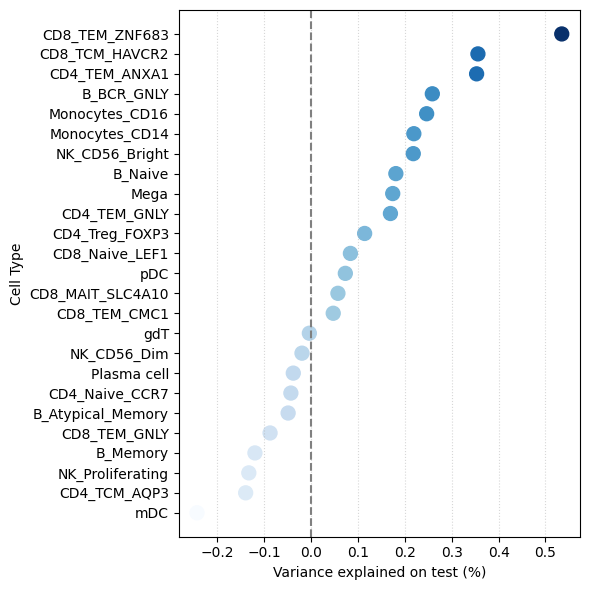

In [18]:
data = pd.concat([adata.obs[['sampleName','primary_type','secondary_type','age']].reset_index(drop=True),
                  pd.DataFrame(adata.obsm['Z_mrvi']).reset_index(drop=True)], axis=1)
data = data.drop(columns='primary_type').groupby(['sampleName','secondary_type','age']).mean().reset_index()
data = data.dropna()
data.sampleName = data.sampleName.astype('str')
data.secondary_type = data.secondary_type.astype('str')
data.age = data.age.astype('float')
report = evaluate_cell_types(data, train_model)
draw_results(report)